# CS-VQE usage

Here we run through a simple example of CS-VQE to simulate a small test molucule for varying quantum resource expenditure.

In [1]:
import cs_vqe_classes.cs_vqe_circuit as cs_circ
import utils.cs_vqe_tools as cs_tools
import utils.plotting_tools as plot
from utils.molecule_tools import get_molecule
from matplotlib import pyplot as plt

/home/tim/anaconda3/lib/python3.7/site-packages/qiskit/aqua/components/optimizers/optimizer.py:50: DeprecationWarning: The package qiskit.aqua.components.optimizers is deprecated. It was moved/refactored to qiskit.algorithms.optimizers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  'qiskit.algorithms.optimizers', 'qiskit-terra')


First we construct the calculated molecule, obtaining the corresponding Hamiltonian and UCCSD Ansatz operator:

In [3]:
molecule = get_molecule("H2_3-21G_SINGLET")
ham   = molecule['hamiltonian']
uccsd = molecule['uccsdansatz']
num_qubits = molecule['num_qubits']
num_electrons = molecule['num_electrons']

print('Species name:', molecule['speciesname'])
print('Hamiltonian:',  ham)
print('UCCSD Ansatz:', uccsd)

{'atoms': ['H', 'H'], 'bond_len': 0.7414, 'multiplicity': 1, 'charge': 0, 'basis': '3-21g'}
Species name: H2_3-21g
Hamiltonian: {'IIIIIIII': (2.5799490123759767+0j), 'ZIIIIIII': (-0.2988649178150935+0j), 'YZZZYIII': (0.093803762999592+0j), 'XZZZXIII': (0.093803762999592+0j), 'IZIIIIII': (-0.29886491781509356+0j), 'IYZZZYII': (0.093803762999592+0j), 'IXZZZXII': (0.093803762999592+0j), 'IIZIIIII': (-0.44061266999345294+0j), 'IIYZZZYI': (0.05796738514791065+0j), 'IIXZZZXI': (0.05796738514791065+0j), 'IIIZIIII': (-0.44061266999345294+0j), 'IIIYZZZY': (0.057967385147910694+0j), 'IIIXZZZX': (0.057967385147910694+0j), 'IIIIZIII': (-0.7888965319144876+0j), 'IIIIIZII': (-0.7888965319144878+0j), 'IIIIIIZI': (-1.1217574006077489+0j), 'IIIIIIIZ': (-1.1217574006077486+0j), 'ZZIIIIII': (0.16306743734109705+0j), 'YIZZYIII': (-0.04160969890900233+0j), 'XIZZXIII': (-0.04160969890900233+0j), 'YXXYIIII': (0.022282700268445314+0j), 'YYXXIIII': (-0.022282700268445314+0j), 'XXYYIIII': (-0.022282700268445314

# Create a CS-VQE circuit instance

Our CS-VQE circuit class requires an input Hamiltonian, a noncontextual subset of terms therein, along with the number of qubits and electrons in the full system. The latter is necessary for determining the Hartree-Fock state to be used as the UCCSD reference. 

Optionally, we may specify the qubit inclusion order (by default the optimal ordering will be determined) and choose which rotations to perform (i.e. just those diagonalising G or the additional unitary partitioning A rotations).

In [40]:
print('Hamiltonian is contextual?', cs_tools.contextualQ_ham(ham))
terms_noncon = cs_tools.greedy_dfs(ham, 3, criterion='size')[-1]
mol_circ = cs_circ.cs_vqe_circuit(hamiltonian=ham,
                                  terms_noncon=terms_noncon,
                                  num_qubits=num_qubits,
                                  num_electrons=num_electrons, 
                                  rot_A=True)

print('Noncontextual ground state:', mol_circ.reference_state())

Hamiltonian is contextual? True
Noncontextual ground state: 01000000


Given the number of qubits we wish to simulate, our circ_vqe_circuit instance includes functionality for computing various parameters necessary for constructing a corresponding quantum circuit for our CS-VQE routine:

In [41]:
num_sim_q = 2

print('Qubits Included in Simulation:', mol_circ.sim_qubits(num_sim_q)[0])
print('Mapping onto available qubits:', mol_circ.qubit_map(num_sim_q), '\n')
print('%i-qubit reduced Hamiltonian:'%num_sim_q, mol_circ.ham_reduced[num_sim_q], '\n')
print('%i-qubit reduced Ansatz:'%num_sim_q, mol_circ.project_anz_terms(uccsd, num_sim_q))

Qubits Included in Simulation: (6, 2)
Mapping onto available qubits: {6: 1, 2: 0} 

2-qubit reduced Hamiltonian: {'II': (-0.40415760369688203+0j), 'ZI': (0.1534128959872611+0j), 'YY': (-3.4639291886240375e-09+0j), 'XX': (-3.4639291886240375e-09+0j), 'IZ': (-0.4257614047032444+0j), 'ZZ': (0.10805416692390094+0j)} 

2-qubit reduced Ansatz: {'YX': 0.006163369703848173j, 'XY': -0.006163369703848173j}


# Constructing the CS-VQE circuit

The main feature of the cs_vqe_circuit class is its ability to construct a CS-VQE circuit (within Qiskit) given a specified Ansatz and the number of qubits to simulate. The method has been designed with modularity in mind, with the quantum circuit being defined in separate 'blocks' that can be selected at will. The current blocks that have been implemented are as follows:

- **ref_state_block** initialises the circuit in the refernce state, typically HF_config though for smaller example one may wish to select the most significant basis state in the Hamiltonian spectrum
- **anz_block** gets the reduced Ansatz (as above) and converts it into series of gates using functionality from utils.circuit_tools; by default it will be second-order Trotterized.
- **swap_entgl_block** requires an ancilla qubit and will fix a specified qubit to the single-qubit basis state |0> (typically this will be the 'X index' of the observable A, or if using unitary partitioning it will be the qubit position of the single Pauli Z therein). It does this at the expense of entangling the ancilla with the other qubits.
- **rot_ham_block** implements the noncontextual generator rotations in the quantum circuit
- **rot_A_block** implemetns only the unitary partitioning A rotations in the quantum circuit
- **A_eig_block** uses functionality from utils.eigenstate and forces the quantum state into the +1-eigenspace of A 
- **parity_cascade_block** takes a list of qubits and stores their parity in an ancilla bit, then inserts an input circuit block before reversing the parity computation. It will also compensate for the 'lost parity' as a consequnce of reducing the simulation dimension by introducing an X gate on the ancilla conditional on the parity of qubits not included in the simulation (fixed by the noncontextual ground state).

All of these blocks are compiled in the build_circuit method - let's see this in action...

In [42]:
mol_circ.build_circuit(uccsd, num_sim_q).draw()

/home/tim/anaconda3/lib/python3.7/site-packages/qiskit/circuit/quantumcircuit.py:876: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)


░  ┌───┐                            ┌───┐      ░  ░ ┌─────┐┌───┐»
q_0: ──────░──┤ H ├────────■────────────────■──┤ H ├──────░──░─┤ SDG ├┤ H ├»
     ┌───┐ ░ ┌┴───┴┐┌───┐┌─┴─┐┌──────────┐┌─┴─┐├───┤┌───┐ ░  ░ └┬───┬┘└───┘»
q_1: ┤ X ├─░─┤ SDG ├┤ H ├┤ X ├┤ RZ(P[0]) ├┤ X ├┤ H ├┤ S ├─░──░──┤ H ├──────»
     └───┘ ░ └─────┘└───┘└───┘└──────────┘└───┘└───┘└───┘ ░  ░  └───┘      »
«                           ┌───┐┌───┐ ░  ░  ┌───┐                            »
«q_0: ──■────────────────■──┤ H ├┤ S ├─░──░──┤ H ├────────■────────────────■──»
«     ┌─┴─┐┌──────────┐┌─┴─┐├───┤└───┘ ░  ░ ┌┴───┴┐┌───┐┌─┴─┐┌──────────┐┌─┴─┐»
«q_1: ┤ X ├┤ RZ(P[1]) ├┤ X ├┤ H ├──────░──░─┤ SDG ├┤ H ├┤ X ├┤ RZ(P[0]) ├┤ X ├»
«     └───┘└──────────┘└───┘└───┘      ░  ░ └─────┘└───┘└───┘└──────────┘└───┘»
«     ┌───┐      ░  ░ ┌─────┐┌───┐                      ┌───┐┌───┐ ░ 
«q_0: ┤ H ├──────░──░─┤ SDG ├┤ H ├──■────────────────■──┤ H ├┤ S ├─░─
«     ├───┤┌───┐ ░  ░ └┬───┬┘└───┘┌─┴─┐┌──────────┐┌─┴─┐├───┤└───┘ ░ 
«q_1: ┤ H ├┤ S ├─░──░──┤ H ├──────┤ X ├┤ RZ(P[1]) ├┤ X ├┤ H ├──────░─
«     └───┘└───┘ ░  ░  └───┘      └───┘└──────────┘└───┘└───┘      ░

# Executing the reduced CS-VQE circuits

Finally, we are able to execute our CS-VQE routine with the CS_VQE method, taking as input an Ansatz and the number of qubits to simulate. This returns a python dict with the simulation results:

*   Performing 2-qubit CS-VQE over qubit positions 6, 2 ...


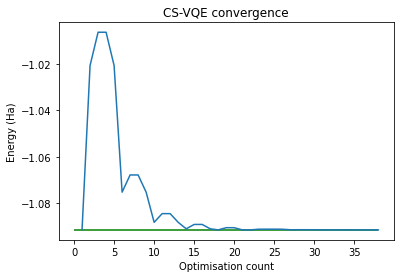

In [43]:
cs_vqe_results = mol_circ.CS_VQE(uccsd, num_sim_q)
plt.title('CS-VQE convergence'), plt.xlabel('Optimisation count'), plt.ylabel('Energy (Ha)')
X, Y = cs_vqe_results['counts'], cs_vqe_results['values']
plt.plot(X, Y)
plt.hlines(cs_vqe_results['target'], 0, X[-1], color='green')

Furthermore, if we wish to compare the CS-VQE results across different numbers of simulation qubits we can use run_cs_vqe, specifying the maximum number of qubits (and optionally the minumum number) to be included. The resulting data can be plotted with utils.plotting_tools.plot_cs_vqe_convergence.

In [ ]:
mol_circ.run_cs_vqe(uccsd, max_sim_q=8)

*   Performing 1-qubit CS-VQE over qubit positions 6 ...
**  Contextual target: -1.091386071311289 | VQE result: -1.091386071311289
*** Succesfully converged on CS-VQE target energy
 
*   Performing 2-qubit CS-VQE over qubit positions 6, 2 ...


/home/tim/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1268: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  RuntimeWarning)


**  Contextual target: -1.091386071311288 | VQE result: -1.091385910860094
*** Succesfully converged on CS-VQE target energy
 
*   Performing 3-qubit CS-VQE over qubit positions 7, 6, 2 ...
**  Contextual target: -1.091386071311287 | VQE result: -1.091386071311281
*** Succesfully converged on CS-VQE target energy
 
*   Performing 4-qubit CS-VQE over qubit positions 7, 6, 2, 0 ...
**  Contextual target: -1.091386071311289 | VQE result: -1.091386071311281
*** Succesfully converged on CS-VQE target energy
 
*   Performing 5-qubit CS-VQE over qubit positions 7, 6, 5, 2, 0 ...
**  Contextual target: -1.095075381190289 | VQE result: -1.091386071311281
*** Did not converge on contextual target | Error =  0.00369
 
*   Performing 6-qubit CS-VQE over qubit positions 7, 6, 5, 4, 2, 0 ...
**  Contextual target: -1.112419615865054 | VQE result: -1.107177437865925
*** Did not converge on contextual target | Error =  0.00524
 
*   Performing 7-qubit CS-VQE over qubit positions 7, 6, 5, 4, 2, 1, 0 ..

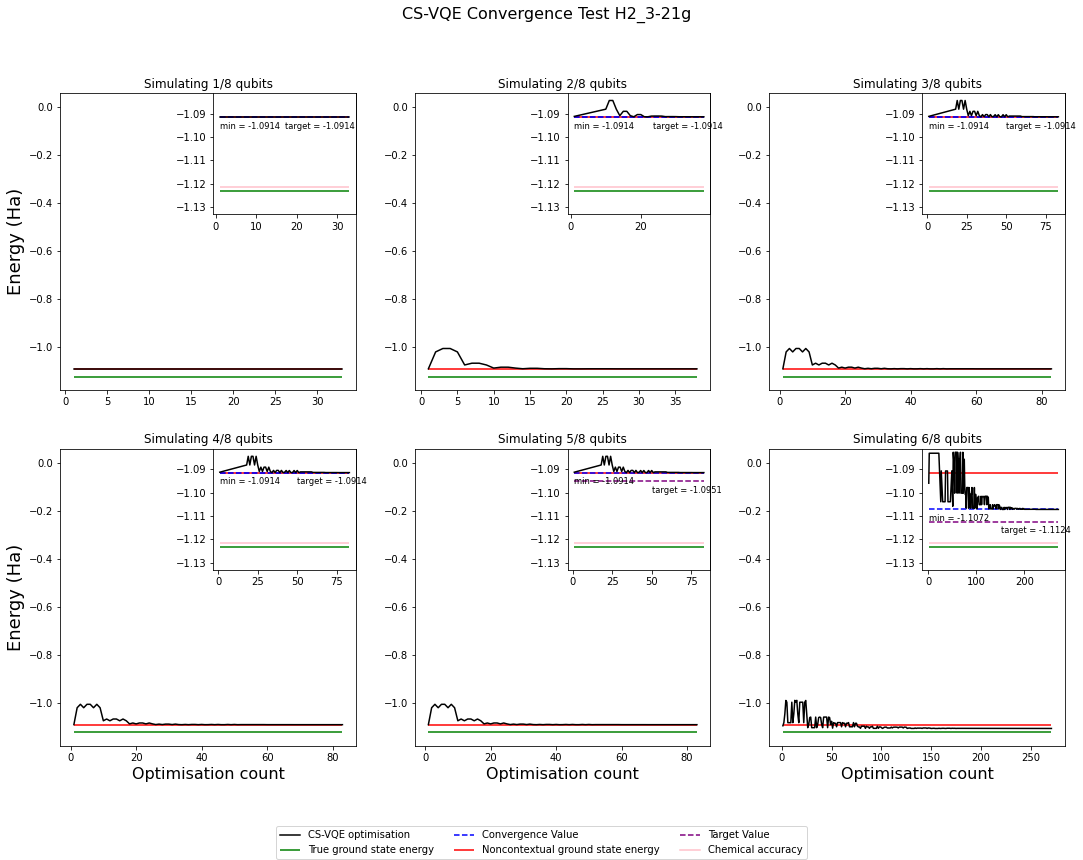

In [45]:
cs_vqe_results = mol_circ.cs_vqe_results
title = 'CS-VQE Convergence Test %s' % molecule['speciesname']
fig = plot.plot_cs_vqe_convergence(data=cs_vqe_results, title=title)

In [ ]:
#fig.savefig("plots/H3-CS-VQE-uccsd_ansatz.png", dpi=300)

In [ ]:
#import json 

#data={}
#for k in cs_vqe_results.keys():
#    data[str(k)] = cs_vqe_results[k]
     
#with open("data/B_STO-3G_singlet_UCCSD_CS-VQE_convergence_projected_ansatz.json", "w") as outfile: 
#    json.dump(data, outfile)

In [ ]:
X = list(range(1, num_qubits+1))
Y1 = []
Y2 = []
for i in X:
    Y1.append(len(mol_circ.project_anz_terms(uccsd, i)))
    Y2.append(mol_circ.build_circuit(uccsd, i).depth())

In [ ]:
plt.plot(X, Y1)
plt.hlines(len(uccsd), 1, X[-1], color='red')
#plt.plot(X, Y2)